In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
data_dir = "dataset/"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb',
          split = ['train[:80%]', 'train[80%:]'], shuffle_files = True, as_supervised = True, with_info = True, data_dir = data_dir )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incomplete2DCR0C/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds, valid_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [4]:
info

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

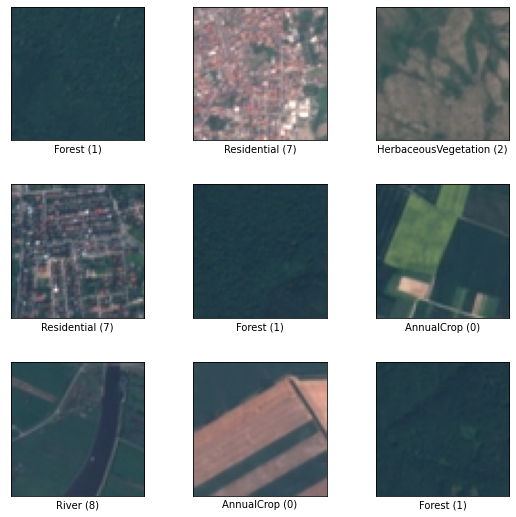

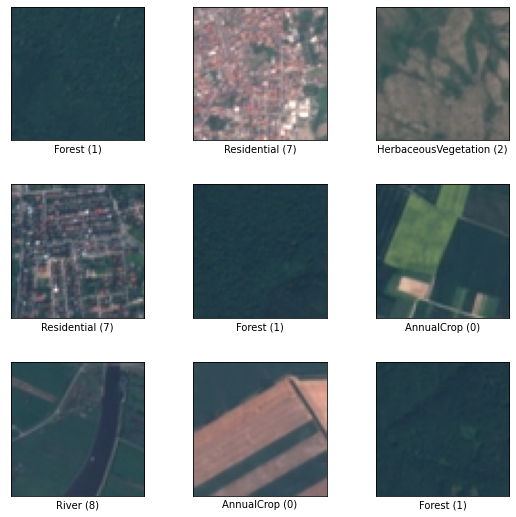

In [5]:
tfds.show_examples(train_ds, info)
# 텐서플로우에서 제공하는 메서드드

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

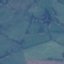
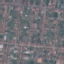
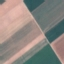
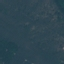
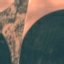
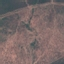
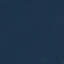
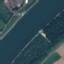
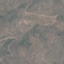
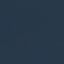

In [6]:
tfds.as_dataframe(valid_ds.take(10), info)

In [7]:
num_classes = info.features['label'].num_classes
num_classes

10

In [8]:
print(info.features['label'].int2str(9))

SeaLake


In [28]:
classlabel = info.features['label']

In [29]:
classlabel.names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [20]:
tf.data.AUTOTUNE

-1

In [9]:
batch_size = 64
buffer_size = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32)/255.
  return image, label


train_data = train_ds.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
# map은 데이터 셋에 함수를 적용할 수 있다.

train_data = train_data.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)



In [60]:
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

def build_model():
  model = Sequential([
      BatchNormalization(),
      Conv2D(32,(3,3), padding = 'same', activation = 'relu'),
      MaxPooling2D((2,2)),

      BatchNormalization(),
      Conv2D(64,(3,3), padding = 'same', activation = 'relu'),
      MaxPooling2D((2,2)),

      Flatten(),
      Dense(128,activation = 'relu'),
      Dropout(0.3),

      Dense(64, activation = 'relu'),
      Dropout(0.3),
      Dense(num_classes, activation = 'softmax')

  ])

  return model

model = build_model()

In [61]:
# model.summary() # 제대로 된게 아니라서 오류...?

In [62]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [63]:
# model.summary()

In [64]:
history = model.fit(train_data, validation_data = valid_data, epochs = 50)

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
def plot_loss_acc(history,epoch):
  loss,val_loss = history.history['loss'],history.history['val_loss']
  acc,val_acc = history.history['acc'],history.history['val_acc']

  fig , axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1,epoch+1), loss, label ='train loss')
  axes[0].plot(range(1,epoch+1), val_loss, label ='valid loss')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1,epoch+1), acc, label ='train acc')
  axes[1].plot(range(1,epoch+1), val_acc, label ='valid acc')
  axes[1].legend(loc='best')
  axes[1].set_title('Acc')

  plt.show()

plot_loss_acc(history,50)

In [34]:
image_batch , label_batch = next(iter(train_data.take(1)))
image_batch.shape, label_batch.shape

(TensorShape([64, 64, 64, 3]), TensorShape([64]))

In [35]:
image = image_batch[7]
label = label_batch[7].numpy()


image, label

(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
 array([[[0.2901961 , 0.4117647 , 0.52156866],
         [0.2901961 , 0.4117647 , 0.52156866],
         [0.26666668, 0.39607844, 0.5176471 ],
         ...,
         [0.31764707, 0.45490196, 0.53333336],
         [0.30980393, 0.45490196, 0.5294118 ],
         [0.30588236, 0.4509804 , 0.52156866]],
 
        [[0.28235295, 0.41568628, 0.5137255 ],
         [0.28235295, 0.42352942, 0.5254902 ],
         [0.2627451 , 0.4       , 0.50980395],
         ...,
         [0.32156864, 0.45882353, 0.5372549 ],
         [0.30588236, 0.4509804 , 0.5254902 ],
         [0.30588236, 0.4509804 , 0.52156866]],
 
        [[0.29411766, 0.45490196, 0.5254902 ],
         [0.28627452, 0.44705883, 0.5254902 ],
         [0.27058825, 0.42745098, 0.5254902 ],
         ...,
         [0.31764707, 0.45490196, 0.5294118 ],
         [0.30980393, 0.44705883, 0.5254902 ],
         [0.3019608 , 0.4392157 , 0.5176471 ]],
 
        ...,
 
        [[0.27450982, 0.41568628, 

Text(0.5, 1.0, 'Pasture')

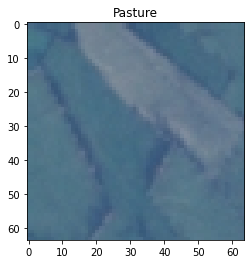

In [36]:
plt.imshow(image)
plt.title(info.features['label'].int2str(label))


In [37]:
def plot_augmentation(original,augmented):
  fig,axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

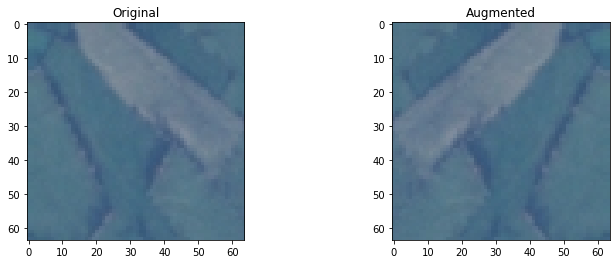

In [38]:
plot_augmentation(image,tf.image.flip_left_right(image))

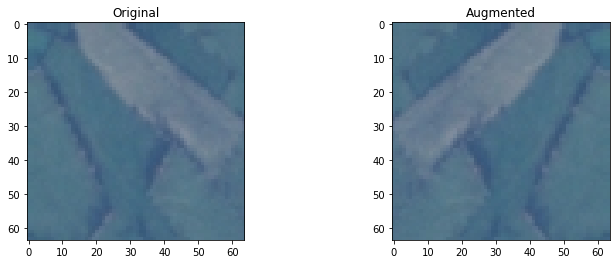

In [39]:
plot_augmentation(image,tf.image.random_flip_left_right(image))

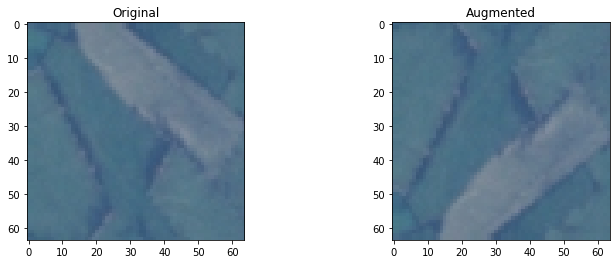

In [40]:
plot_augmentation(image,tf.image.flip_up_down(image))

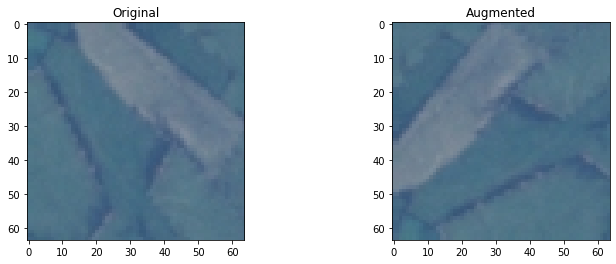

In [41]:
plot_augmentation(image,tf.image.rot90(image))

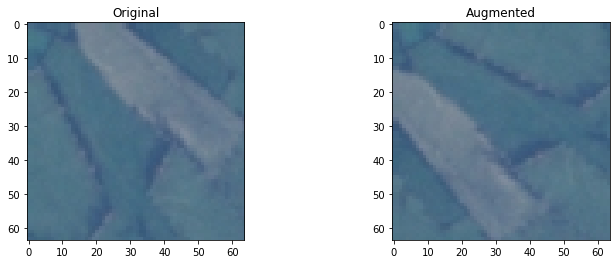

In [42]:
plot_augmentation(image,tf.image.transpose(image))

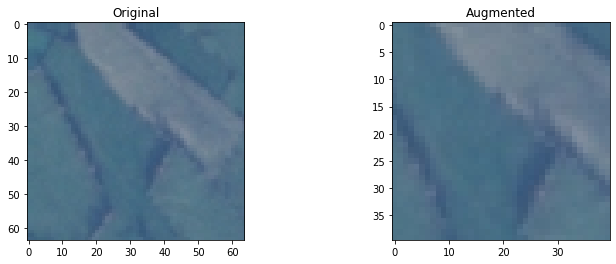

In [43]:
plot_augmentation(image,tf.image.central_crop(image,central_fraction=0.6))

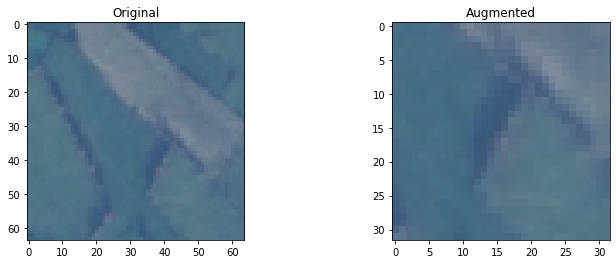

In [44]:
plot_augmentation(image,tf.image.random_crop(image,size=[32,32,3]))
# 확대 위치가 조금씩 달라진다.

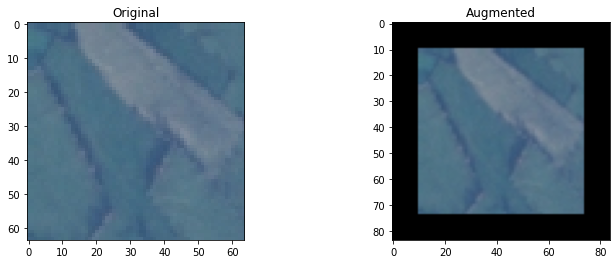

In [45]:
plot_augmentation(image,tf.image.resize_with_crop_or_pad(image,64+20,64+20))

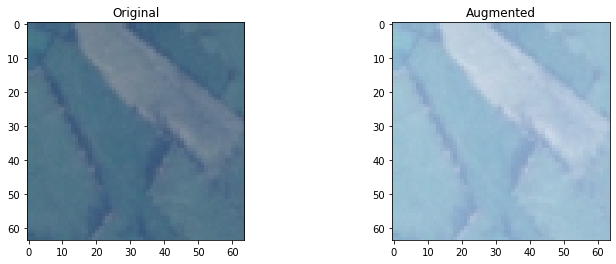

In [46]:
plot_augmentation(image,tf.image.adjust_brightness(image,0.3))

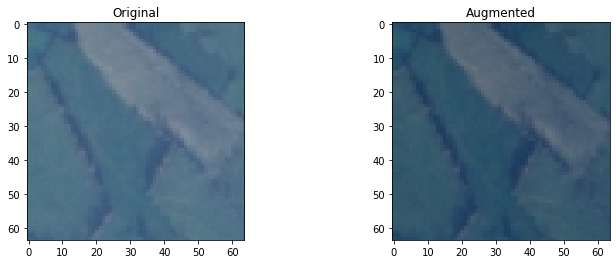

In [47]:
plot_augmentation(image,tf.image.random_brightness(image,0.3))

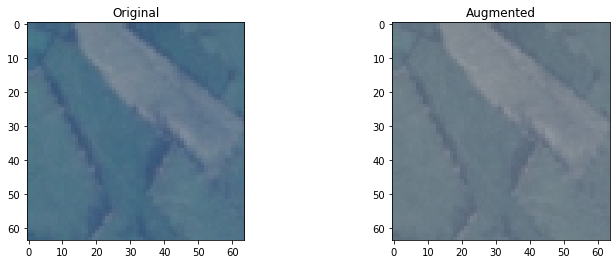

In [48]:
plot_augmentation(image,tf.image.adjust_saturation(image,0.5))

In [49]:
batch_size = 64
buffer_size = 1000

def preprocess_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta = 0.3)
  image = tf.image.random_contrast(image,0.5,1.5)                             
                                     
                                     
  image = tf.cast(image, tf.float32)/255.
  return image, label


train_aug = train_ds.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
valid_aug = valid_ds.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
# map은 데이터 셋에 함수를 적용할 수 있다.

train_aug = train_aug.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

Text(0.5, 1.0, 'Industrial')

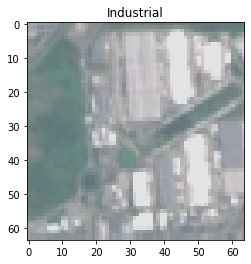

In [50]:
image_batch , label_batch = next(iter(train_aug.take(1)))
image_batch.shape,label_batch.shape

image = image_batch[0]
label = label_batch[0].numpy()
# image,label

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

Epoch 1/50
338/338 [==============================] - 10s 26ms/step - loss: 1.9552 - acc: 0.2908 - val_loss: 1.7835 - val_acc: 0.3765
Epoch 2/50
338/338 [==============================] - 7s 22ms/step - loss: 1.6947 - acc: 0.3545 - val_loss: 1.5218 - val_acc: 0.4457
Epoch 3/50
338/338 [==============================] - 8s 22ms/step - loss: 1.5573 - acc: 0.4160 - val_loss: 1.3853 - val_acc: 0.4935
Epoch 4/50
338/338 [==============================] - 7s 21ms/step - loss: 1.4525 - acc: 0.4600 - val_loss: 1.1654 - val_acc: 0.6091
Epoch 5/50
338/338 [==============================] - 7s 21ms/step - loss: 1.3301 - acc: 0.5160 - val_loss: 1.1563 - val_acc: 0.6091
Epoch 6/50
338/338 [==============================] - 7s 21ms/step - loss: 1.2700 - acc: 0.5412 - val_loss: 1.1097 - val_acc: 0.6161
Epoch 7/50
338/338 [==============================] - 8s 21ms/step - loss: 1.2156 - acc: 0.5647 - val_loss: 1.0114 - val_acc: 0.6700
Epoch 8/50
338/338 [==============================] - 7s 21ms/step -

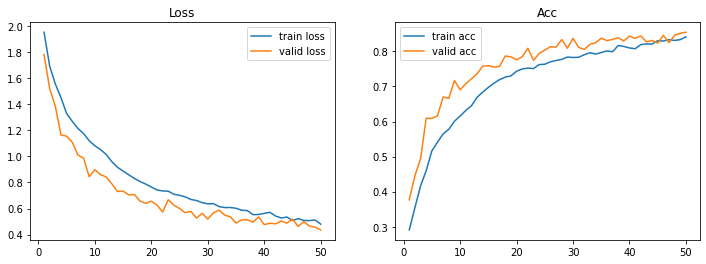

In [51]:
aug_model = build_model()
aug_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
aug_history = aug_model.fit(train_aug, validation_data = valid_aug, epochs = 50)

plot_loss_acc(aug_history,50)

# 위의 경우와 그래프를 비교하면 성능이 좋지는 않지만, 과적합 문제가 아직 일어나지 않았음을 알 수 있다.
# 에폭 수를 늘린다면 추가적인 성능향상을 기대할 수 있다.

In [52]:
from keras.applications import ResNet50V2
from keras.utils import plot_model

pre_trained_base = ResNet50V2()
plot_model(pre_trained_base, show_shapes = True, show_layer_names = True)

Output hidden; open in https://colab.research.google.com to view.

In [53]:
from keras.applications import ResNet50V2
from keras.utils import plot_model

pre_trained_base = ResNet50V2(include_top = False, input_shape= [64,64,3])
pre_trained_base.trainable = False

plot_model(pre_trained_base, show_shapes = True, show_layer_names = True)

Output hidden; open in https://colab.research.google.com to view.

In [54]:
pre_trained_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [55]:
def build_trainsfer_model():
  model = Sequential([
      pre_trained_base,

      Flatten(),
      Dense(128,activation='relu'),
      Dropout(0.3),

      Dense(64,activation='relu'),
      Dropout(0.3),
      Dense(num_classes,activation='softmax'),

  ])
  return model

In [56]:
t_model = build_trainsfer_model()
t_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

Epoch 1/50
338/338 [==============================] - 17s 38ms/step - loss: 1.0868 - acc: 0.6454 - val_loss: 0.6930 - val_acc: 0.7769
Epoch 2/50
338/338 [==============================] - 11s 32ms/step - loss: 0.7979 - acc: 0.7462 - val_loss: 0.5844 - val_acc: 0.8019
Epoch 3/50
338/338 [==============================] - 10s 30ms/step - loss: 0.7135 - acc: 0.7698 - val_loss: 0.5601 - val_acc: 0.8133
Epoch 4/50
338/338 [==============================] - 11s 31ms/step - loss: 0.6745 - acc: 0.7792 - val_loss: 0.5393 - val_acc: 0.8198
Epoch 5/50
338/338 [==============================] - 10s 30ms/step - loss: 0.6195 - acc: 0.7961 - val_loss: 0.5251 - val_acc: 0.8187
Epoch 6/50
338/338 [==============================] - 11s 32ms/step - loss: 0.6051 - acc: 0.8013 - val_loss: 0.5040 - val_acc: 0.8328
Epoch 7/50
338/338 [==============================] - 10s 30ms/step - loss: 0.5862 - acc: 0.8093 - val_loss: 0.4985 - val_acc: 0.8354
Epoch 8/50
338/338 [==============================] - 11s 31ms

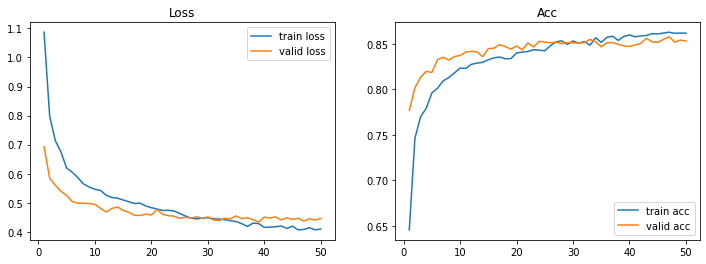

In [57]:

t_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
t_history = t_model.fit(train_aug, validation_data = valid_aug, epochs = 50)

plot_loss_acc(t_history,50)


In [58]:
pred = t_model.predict(image.numpy().reshape(-1,64,64,3))
# 차원을 맞춰준 다음에 입력력
pred

1/1 [==============================] - 1s 1s/step


array([[7.4520702e-03, 6.5550084e-05, 1.8647916e-03, 5.1516369e-02,
        6.9988436e-01, 6.9443774e-03, 3.3244189e-02, 2.2189382e-02,
        1.7667146e-01, 1.6743252e-04]], dtype=float32)

In [59]:
print(info.features['label'].int2str(np.argmax(pred)))

Industrial
